## q<sup>2</sup> Tutorial - 2. Solving for stellar parameters

MOOG is frequently used to derive atmospheric parameters of stars. It doesn't actually do it by itself, but it allows us to do the basic calculations required to achieve that goal. q<sup>2</sup> helps us talk to MOOG and perform these tasks.

First, import q<sup>2</sup> and load the data (this is the same data set used in the Introduction). We are also defining an arcturus Star object and assigning it the input data.

*The "%matplotlib inline" command allows the images created by q2 to be shown on the IPython notebook.*

In [1]:
import q2

data = q2.Data('standards_stars.csv', 'standards_lines.csv')
arcturus = q2.Star('Arcturus')
arcturus.get_data_from(data)

%matplotlib inline

In the Introduction, we used the q2.specpars module to calculate iron_stats for a fixed set of parameters. Now we can use it to solve for better parameters ("better" here means consistent with 1D-LTE excitation/ionization equilibrium).

First, we need to define some parameters for the solution procedure. We will do that by creating a SolvePars object that we are calling "sp" below. Starting from the input Teff, logg, and vt, q<sup>2</sup> will try to find those values that minimize the slopes of iron abundance versus line EP and REW as well as match the average FeI and FeII abundances. This is an iterative procedure. We can set the initial steps for the changes to be applied to those parameters (step_teff, step_logg, etc.) using the sp SolvePars object. Also, it is a good idea to set a maximum number of iterations (niter) in case q<sup>2</sup> is not able to converge quickly (or at all). At this point we can also set the model atmosphere grid we want to use. In this example we are using MARCS models again.

Note that we are using a PlotPars object called "pp" to make our output figure look a bit nicer than the default. In this example, we are forcing the y-axis of the figures to extend from -0.25 dex to +0.25 from the average iron abundance measured (i.e., the full y-axis range is 0.5 dex).

The q2.specpars.solve_one function does all the work for us. This may take a while:

it Teff logg [Fe/H]  vt           [Fe/H]
-- ---- ---- ------ ----      --------------
 0 4286 1.66 -0.520 1.74 --->  6.875+/-0.066
 1 4294 1.58 -0.575 1.66 --->  6.862+/-0.054
 2 4302 1.50 -0.588 1.58 --->  6.853+/-0.055
 3 4294 1.58 -0.597 1.66 --->  6.860+/-0.054
 4 4302 1.50 -0.590 1.58 --->  6.852+/-0.055
-- Converged at iteration 4 of 35
 5 4298 1.54 -0.598 1.62 --->  6.856+/-0.053
 6 4302 1.58 -0.594 1.66 --->  6.858+/-0.053
 7 4306 1.54 -0.592 1.62 --->  6.855+/-0.053
 8 4310 1.58 -0.595 1.66 --->  6.856+/-0.053
 9 4314 1.62 -0.594 1.62 --->  6.885+/-0.053
10 4310 1.58 -0.565 1.66 --->  6.860+/-0.053
11 4314 1.54 -0.590 1.62 --->  6.854+/-0.054
-- Converged at iteration 11 of 35
12 4316 1.56 -0.596 1.64 --->  6.854+/-0.053
13 4318 1.58 -0.596 1.66 --->  6.855+/-0.053
14 4320 1.60 -0.595 1.64 --->  6.869+/-0.053
15 4322 1.62 -0.581 1.66 --->  6.871+/-0.053
16 4324 1.60 -0.579 1.64 --->  6.870+/-0.053
17 4322 1.62 -0.580 1.66 --->  6.871+/-0.053
18 4324 1.60 -0.579 1.64 --->  6.87

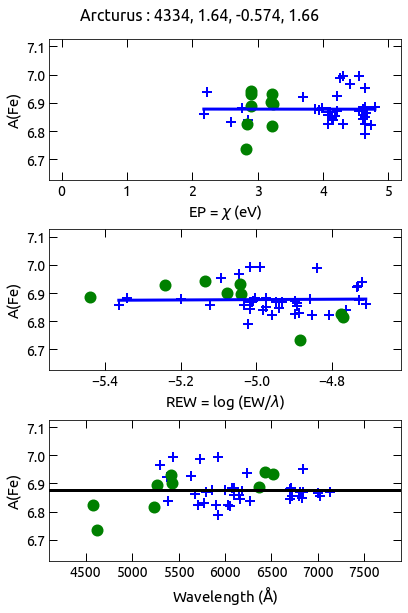

In [2]:
sp = q2.specpars.SolvePars()
sp.step_teff = 8
sp.step_logg = 0.08
sp.step_vt = 0.08
sp.niter = 35
sp.grid = 'marcs'

pp = q2.specpars.PlotPars()
pp.afe = [-1000, 0.25]

q2.specpars.solve_one(arcturus, sp, PlotPars=pp)

In each iteration, the parameters have changed in order to approach spectroscopic equilibrium. After the parameters converge within the initial steps, they are divided by 2 and a new iteration block begins. This is done repeatedly until the steps are 1 K, 0.01 dex, and 0.01 dex (final loop).

We have found the Teff/logg/vt combination that makes Arcturus' iron abundances independent of EP and REW, and also the FeI and FeII abundances match. A hardcopy of this figure is created as well, with the id of the star object as the file name ("Arcturus.png" in this example).

Note that the y-axis here is A(Fe), i.e., the absolute iron abundance. We can repeat this calculation, but using the solar EW values to calculate differential abundances and parameters of Arcturus. As before, to calculate differential abundances we pass a Ref object, sun, to q2.specpars.solve_one. This object should have its input data assigned to it before performing any abundance calculations (hence the get_data_from step):

it Teff logg [Fe/H]  vt           [Fe/H]
-- ---- ---- ------ ----      --------------
 0 4334 1.64 -0.574 1.66 ---> -0.542+/-0.026
 1 4342 1.56 -0.542 1.58 ---> -0.541+/-0.028
 2 4334 1.64 -0.541 1.66 ---> -0.538+/-0.027
 3 4342 1.56 -0.538 1.58 ---> -0.541+/-0.028
 4 4334 1.64 -0.541 1.66 ---> -0.538+/-0.027
-- Converged at iteration 4 of 35
 5 4338 1.60 -0.538 1.62 ---> -0.539+/-0.024
 6 4342 1.56 -0.539 1.66 ---> -0.570+/-0.025
 7 4346 1.60 -0.570 1.62 ---> -0.544+/-0.025
 8 4342 1.64 -0.544 1.66 ---> -0.540+/-0.025
 9 4346 1.60 -0.540 1.62 ---> -0.541+/-0.024
-- Converged at iteration 9 of 35
10 4344 1.62 -0.541 1.64 ---> -0.540+/-0.024
11 4346 1.60 -0.540 1.66 ---> -0.555+/-0.024
12 4348 1.62 -0.555 1.64 ---> -0.543+/-0.023
13 4350 1.60 -0.543 1.66 ---> -0.556+/-0.024
14 4352 1.62 -0.556 1.64 ---> -0.544+/-0.024
15 4350 1.64 -0.544 1.66 ---> -0.542+/-0.023
16 4352 1.62 -0.542 1.68 ---> -0.556+/-0.024
-- Converged at iteration 16 of 35
-- Begin final loop
17 4353 1.61 -0.556 1.67 -

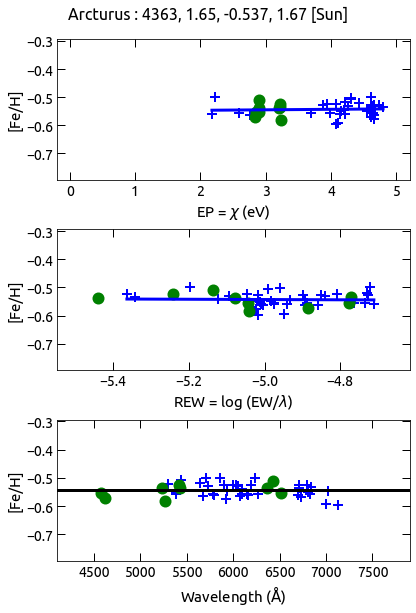

In [3]:
sun = q2.Star('Sun')
sun.get_data_from(data)

q2.specpars.solve_one(arcturus, sp, Ref=sun, PlotPars=pp)

A hardcopy of the figure shown above is created, as usual. The file name follows the convention: "Star.name-Ref.name" ("Arcturus-Sun.png" in this example).

The iron_stats attribute of the star object is updated in every iteration. The last one contains our 'final' solution (if it converged). The same is true for the stellar parameters. Note also that the parameters of the object itself have been modified by this procedure (i.e., they are no longer the parameters listed in the csv file):

In [4]:
print("[Fe/H](Fe I)  = {0:5.3f} +/- {1:5.3f}".\
      format(arcturus.iron_stats['afe1'], arcturus.iron_stats['err_afe1']))
print("[Fe/H](Fe II) = {0:5.3f} +/- {1:5.3f}".\
      format(arcturus.iron_stats['afe2'], arcturus.iron_stats['err_afe2']))
print("A(FeI) vs. EP slope  = {0:.6f}".format(arcturus.iron_stats['slope_ep']))
print("A(FeI) vs. REW slope = {0:.6f}".format(arcturus.iron_stats['slope_rew']))

print("Final stellar parameters:")
print("Teff = {0:4.0f} K, logg = {1:4.2f}, [Fe/H]= {2:5.2f}, vt = {3:4.2f} km/s".\
      format(arcturus.teff, arcturus.logg, arcturus.feh, arcturus.vt))

print("")
print(arcturus)

[Fe/H](Fe I)  = -0.543 +/- 0.024
[Fe/H](Fe II) = -0.545 +/- 0.023
A(FeI) vs. EP slope  = 0.001743
A(FeI) vs. REW slope = -0.004741
Final stellar parameters:
Teff = 4363 K, logg = 1.65, [Fe/H]= -0.54, vt = 1.67 km/s

Star object named 'Arcturus':
  Teff (K) = 4363.0, logg [cgs] = 1.65, [Fe/H] = -0.537, vt (km/s) = 1.67
  Spectral lines = 46 (species: 26.0,26.1)
  Model atmosphere: marcs


To calculate formal errors for our solution parameters we use the q2.errors.error_one function. When it is done calculating the errors, q<sup>2</sup> adds a sp_err attribute, containing those errors, to the star object:

In [5]:
q2.errors.error_one(arcturus, sp, Ref=sun)
print("err_Teff = {0:2.0f} K, err_logg = {1:4.2f}, err_[Fe/H] = {2:4.2f}, err_vt = {3:4.2f}".\
      format(arcturus.sp_err['teff'], arcturus.sp_err['logg'], arcturus.sp_err['afe'], arcturus.sp_err['vt']))

err_Teff = 36 K, err_logg = 0.12, err_[Fe/H] = 0.04, err_vt = 0.05


These values correspond to the precision of this technique at minimizing Fe abundance trends and FeI vs FeII iron abundance differences. We have to be careful and not report these errors as the true uncertainties in the star's parameters or iron abundance. The latter are dominated by systematic uncertainties.

q<sup>2</sup>'s solutions are not necessarily unique. The final Teff, logg, etc. parameters that we derive will be somewhat dependent on the initial guess parameters and parameter steps (try it!). The solve_one function inside the q2.specpars module is the one actually finding the solution. It is there that one should go for improvements to the solution method. However, for most purposes, these solutions are good enough.

This concludes Part 2 of the Tutorial. We have learned how to solve for Teff/logg etc. using the standard spectroscopic method for one star: Arcturus. But what do we do if we have a sample of many stars instead of just one problem star? Let's move on to Part 3 to find out.